## Imports

In [ ]:
!pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import os
from functools import partial

from IPython.display import clear_output
from tqdm import tqdm

In [ ]:
!git clone https://github.com/NVlabs/denoising-diffusion-gan.git ddgan
!touch ddgan/datasets_prep/__init__.py
!touch ddgan/__init__.py

import sys
sys.path.append('/content/')
sys.path.append('/content/ddgan')

Cloning into 'ddgan'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 120 (delta 2), reused 2 (delta 2), pack-reused 101
Receiving objects: 100% (120/120), 83.07 MiB | 36.00 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
from ddgan.EMA import EMA
from ddgan.train_ddgan import Diffusion_Coefficients, Posterior_Coefficients,\
                              get_time_schedule, q_sample_pairs, sample_posterior,\
                              sample_from_model, extract

In [ ]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

In [ ]:
!rm -rf toySB

In [ ]:
!git clone  --recurse-submodules https://github.com/David-cripto/toySB.git toySB
!touch toySB/toysb/__init__.py
!touch toySB/__init__.py

import sys
sys.path.append('/content/')
sys.path.append('/content/toySB')

Cloning into 'toySB'...
remote: Enumerating objects: 364, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 364 (delta 37), reused 39 (delta 30), pack-reused 303
Receiving objects: 100% (364/364), 1.79 MiB | 6.73 MiB/s, done.
Resolving deltas: 100% (197/197), done.
Submodule 'I2SB' (https://github.com/David-cripto/I2SB) registered for path 'I2SB'
Submodule 'deis' (https://github.com/David-cripto/deis) registered for path 'deis'
Cloning into '/content/toySB/I2SB'...
remote: Enumerating objects: 81, done.        
remote: Counting objects: 100% (31/31), done.        
remote: Compressing objects: 100% (24/24), done.        
remote: Total 81 (delta 10), reused 12 (delta 7), pack-reused 50        
Receiving objects: 100% (81/81), 8.45 MiB | 11.99 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Cloning into '/content/toySB/deis'...
remote: Enumerating objects: 238, done.        
remote: Counting objects: 100% (30/30), done.  

## Datasets generation

In [ ]:
from sklearn import datasets
import torch as th
from torch.utils.data import Dataset
from pathlib import Path

PathLike = Path | str

def get_dataset(n_samples, name_dataset):
    if name_dataset == "scurve":
        X, y  = datasets.make_s_curve(n_samples=n_samples, noise=0.0, random_state=None)
        init_sample = th.tensor(X)[:,[0,2]]
        scaling_factor = 7
        init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
        dim = init_sample.shape[1]

    elif name_dataset == "swiss":
        X, y  = datasets.make_swiss_roll(n_samples=n_samples, noise=0.0, random_state=None)
        init_sample = th.tensor(X)[:,[0,2]]
        scaling_factor = 7
        init_sample = (init_sample - init_sample.mean()) / init_sample.std() * scaling_factor
        dim = init_sample.shape[1]

    init_sample = init_sample.float()

    return init_sample, dim

def get_pair_dataset(
        n_samples: int, dataset1: str, dataset2: str,
        transforms = None,
        path_to_save: PathLike = None, regime: str = "train"
        ):
    samples1, dim = get_dataset(n_samples, dataset1)
    samples2, dim = get_dataset(n_samples, dataset2)

    if path_to_save is not None:
        path_to_save = Path(path_to_save) / regime
        path_to_save.mkdir(exist_ok=True)
        path1, path2 = str(path_to_save / "samples1.th"), str(path_to_save / "samples2.th")
        th.save(samples1, path1)
        # logger.info(f"[Dataset] Save {dataset1} to {path1}")
        th.save(samples2, path2)
        # logger.info(f"[Dataset] Save {dataset2} to {path2}")

    class PairDataset(Dataset):
        def __init__(self):
            self.samples1 = transforms(samples1) if transforms is not None else samples1
            self.samples2 = transforms(samples2) if transforms is not None else samples2

        def __len__(self):
            return len(self.samples1)

        def __getitem__(self, index):
            return self.samples1[index], self.samples2[index]
    # logger.info(f"[Dataset] Built {dataset1} and {dataset2} datasets, size={len(samples1)}!")
    return PairDataset(), dim

def load_dataset(path_to_dataset: PathLike, logger, transforms = None):
    # logger.info(f"[Dataset] Load dataset from {path_to_dataset}")
    dataset = th.load(path_to_dataset)

    dim = dataset.shape[1]

    class PairDataset(Dataset):
        def __init__(self):
            self.samples = transforms(dataset) if transforms is not None else dataset

        def __len__(self):
            return len(self.samples)

        def __getitem__(self, index):
            return self.samples[index], self.samples[index]

    return PairDataset(), dim

## Utils

In [ ]:
import torch as th
from torch.optim import AdamW, lr_scheduler
import torch.nn.functional as F
# from torch_ema import ExponentialMovingAverage
import os
# from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import torchvision

IMAGE_CONSTANTS = {
    "scale":1,
    "width":0.002,
    "x_range":(-15,15),
    "y_range":(-15,15),
    "figsize":(20,10)
}

def compute_gaussian_product_coef(sigma1, sigma2):
    """ Given p1 = N(x_t|x_0, sigma_1**2) and p2 = N(x_t|x_1, sigma_2**2)
        return p1 * p2 = N(x_t| coef1 * x0 + coef2 * x1, var) """

    denom = sigma1**2 + sigma2**2
    coef1 = sigma2**2 / denom
    coef2 = sigma1**2 / denom
    var = (sigma1**2 * sigma2**2) / denom
    return coef1, coef2, var

def unsqueeze_xdim(z, xdim):
    bc_dim = (...,) + (None,) * len(xdim)
    return z[bc_dim]

def make_beta_schedule(n_timestep=1000, linear_start=1e-4, linear_end=2e-2):
    betas = (
        th.linspace(linear_start ** 0.5, linear_end ** 0.5, n_timestep, dtype=th.float64) ** 2
    )
    return betas.numpy()

def create_symmetric_beta_schedule(n_timestep, *args, **kwargs):
    import numpy as np
    betas = make_beta_schedule(n_timestep=n_timestep, *args, **kwargs)
    betas = np.concatenate([betas[:n_timestep//2], np.flip(betas[:n_timestep//2])])
    return betas

def build_optimizer_sched(opt, net, logger):
    optim_dict = {"lr": opt.lr, 'weight_decay': opt.l2_norm}
    optimizer = AdamW(net.parameters(), **optim_dict)
    logger.info(f"[Opt] Built AdamW optimizer {optim_dict=}!")

    if opt.lr_gamma < 1.0:
        sched_dict = {"step_size": opt.lr_step, 'gamma': opt.lr_gamma}
        sched = lr_scheduler.StepLR(optimizer, **sched_dict)
        logger.info(f"[Opt] Built lr step scheduler {sched_dict=}!")
    else:
        sched = None

    return optimizer, sched

def space_indices(num_steps, count):
    assert count <= num_steps

    if count <= 1:
        frac_stride = 1
    else:
        frac_stride = (num_steps - 1) / (count - 1)

    cur_idx = 0.0
    taken_steps = []
    for _ in range(count):
        taken_steps.append(round(cur_idx))
        cur_idx += frac_stride

    return taken_steps

class TensorBoardWriter:
    def __init__(self, opt):
        run_dir = str(opt.log_dir / opt.name)
        os.makedirs(run_dir, exist_ok=True)
        self.writer=SummaryWriter(log_dir=run_dir, flush_secs=20)

    def add_scalar(self, global_step, key, val):
        self.writer.add_scalar(key, val, global_step=global_step)

    def add_figure(self, global_step, key, val):
        self.writer.add_figure(key, val, global_step=global_step)

    def close(self):
        self.writer.close()

def compute_pred_x0(step, xt, net_out, scheduler):
    std_fwd = scheduler.get_std_fwd(step, xdim=xt.shape[1:])
    pred_x0 = xt - std_fwd * net_out
    return pred_x0

def visualize2d(xs, x0, log_steps):
    fig, axs = plt.subplots(1, xs.shape[1] + 1, figsize = (20, 10))

    axs[0].scatter(x0[:, 0], x0[:, 1], c = list(range(len(x0))))
    axs[0].set_title(f"True labels")

    for ind in range(1, xs.shape[1] + 1):
        points_t = xs[:, ind - 1, :]
        axs[ind].scatter(points_t[:, 0], points_t[:, 1], c = list(range(len(points_t))))
        axs[ind].set_title(f"Points at time {log_steps[ind - 1]}")

    return fig

def visualize(xs, x0, log_steps):
    fig, axs = plt.subplots(nrows = xs.shape[0], ncols=xs.shape[1] + 1, squeeze=False, figsize = (30, 20))
    for j, batch in enumerate(xs):
        img = torchvision.transforms.functional.to_pil_image((th.clamp(x0[j], -1., 1.) + 1)/2)
        axs[j, 0].imshow(np.asarray(img))
        axs[j, 0].set_title(f"True image")
        axs[j, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for i, img in enumerate(batch):
            img = img.detach()
            img = torchvision.transforms.functional.to_pil_image((th.clamp(img, -1., 1.) + 1)/2)
            axs[j, i + 1].imshow(np.asarray(img))
            axs[j, i + 1].set_title(f"Time = {log_steps[i]}")
            axs[j, i + 1].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    return fig

def save_imgs2d(log_steps, path_to_save, draw_dict):
    path_to_save = Path(path_to_save)

    for ind in range(len(log_steps)):
        plt.figure(figsize = IMAGE_CONSTANTS["figsize"])
        for name, vals in draw_dict.items():
            xs = vals["log_steps"]
            points_t = xs[:, ind, :]
            plt.scatter(points_t[:, 0], points_t[:, 1], c = vals["color"], label = name)
            plt.title(f"Points at time {log_steps[ind]}")
            if ind != 0:
                plt.quiver(points_t[:, 0], points_t[:, 1], vals["vel"][:, ind - 1, 0], vals["vel"][:, ind - 1, 1],
                        angles='xy', scale_units='xy', scale=IMAGE_CONSTANTS["scale"],
                        label = name, width =IMAGE_CONSTANTS["width"], color = vals["color"],
                        alpha = 0.3)

            plt.legend()
            plt.xlim(*IMAGE_CONSTANTS["x_range"])
            plt.ylim(*IMAGE_CONSTANTS["y_range"])
            plt.savefig(str(path_to_save / f"{log_steps[ind]}.png"))

def save_imgs(xs, log_steps, path_to_save):
    path_to_save = Path(path_to_save)
    for ind, batch in enumerate(xs):
        path_to_dir = path_to_save / f"{ind}"
        path_to_dir.mkdir(exist_ok=True)

        for num_timestep, image in enumerate(batch):
            plt.figure(figsize = IMAGE_CONSTANTS["figsize"])
            plt.imshow(np.asarray(torchvision.transforms.functional.to_pil_image((th.clamp(image, -1., 1.) + 1)/2)))
            plt.axis("off")
            plt.title(f"Time = {log_steps[num_timestep]}")
            plt.savefig(str(path_to_dir / f"{log_steps[num_timestep]}.png"))


@th.no_grad()
def sampling(opt, val_dataloader, net, ema, scheduler, path_to_save = None):
    steps = space_indices(opt.num_steps, opt.nfe)
    log_steps = [steps[i] for i in space_indices(len(steps), opt.log_count)]

    for x0, x1 in val_dataloader:
        break

    x1 = x1.detach().to(opt.device)

    draw_dict = {}

    with ema.average_parameters():
        net.eval()

        if opt.exp_int:
            def pred_eps_fn(xt, scalar_t):
                vec_t = th.full((xt.shape[0],), scalar_t, device=xt.device, dtype=th.long)
                out = net(xt, vec_t)
                return out
            xs, pred_x0 = scheduler.exp_sampling(steps, pred_eps_fn, x1, log_steps=log_steps, ab_order = opt.ab_order)

            draw_dict[f"Exponential integrator with ab_order = {opt.ab_order}"] = {
                "log_steps" : xs, "vel" : xs[:, :-1, :] - xs[:, 1:, :], "color" : "#CA6F1E"
                }
        if opt.ot_ode:
            def pred_x0_fn(xt, step):
                step = th.full((xt.shape[0],), step, device=opt.device, dtype=th.long)
                out = net(xt, step)
                return compute_pred_x0(step, xt, out, scheduler)
            xs, pred_x0 = scheduler.ddpm_sampling(steps, pred_x0_fn, x1, ot_ode=True, log_steps=log_steps, verbose=True)
            draw_dict["OT ODE"] = {"log_steps" : xs, "vel" : xs[:, :-1, :] - xs[:, 1:, :], "color" : "#BB8FCE"}
        if opt.ddpm:
            def pred_x0_fn(xt, step):
                step = th.full((xt.shape[0],), step, device=opt.device, dtype=th.long)
                out = net(xt, step)
                return compute_pred_x0(step, xt, out, scheduler)
            xs, pred_x0 = scheduler.ddpm_sampling(steps, pred_x0_fn, x1, ot_ode=False, log_steps=log_steps, verbose=True)
            draw_dict["DDPM"] = {"log_steps" : xs, "vel" : xs[:, :-1, :] - xs[:, 1:, :], "color" : "#B03A2E"}

    if path_to_save is not None:
        if len(xs.shape) <= 3:
            save_imgs2d(log_steps, path_to_save, draw_dict)
        else:
            save_imgs(xs, log_steps, path_to_save)


    figure = visualize2d(xs, x0, log_steps) if len(xs.shape) <= 3 else visualize(xs, x0, log_steps)

    return figure


# def train(opt, net, scheduler, train_dataloader, val_dataloader, logger):
#     writer = TensorBoardWriter(opt)
#     ema = ExponentialMovingAverage(net.parameters(), decay=opt.ema)
#     noise_levels = th.linspace(opt.t0, opt.T, opt.num_steps, device=opt.device) * opt.num_steps

#     ema.to(opt.device)
#     net.to(opt.device)

#     optimizer, sched = build_optimizer_sched(opt, net, logger)

#     net.train()

#     for it in range(opt.num_epoch):
#         for x0, x1 in train_dataloader:
#             optimizer.zero_grad()
#             x0, x1 = x0.detach().to(opt.device), x1.detach().to(opt.device)
#             step = th.randint(0, opt.num_steps, (x0.shape[0],))
#             xt = scheduler.q_sample(step, x0, x1, ot_ode = opt.ot_ode)
#             eps_true = scheduler.compute_label(step, x0, xt)
#             eps_pred = net(xt, noise_levels[step].detach())

#             loss = F.mse_loss(eps_pred, eps_true)
#             loss.backward()
#             optimizer.step()
#             ema.update()
#             if sched is not None: sched.step()
#         logger.info("train_it {}/{} | lr:{} | loss:{}".format(
#                     1+it,
#                     opt.num_epoch,
#                     "{:.2e}".format(optimizer.param_groups[0]['lr']),
#                     "{:+.4f}".format(loss.item()),
#                 ))
#         if it % 5 == 0:
#             writer.add_scalar(it, 'loss', loss.detach())

#         if it % 10 == 0:
#             net.eval()
#             logger.info(f"Evaluation started: iter={it}")
#             figure = sampling(opt, val_dataloader, net, ema, scheduler)
#             writer.add_figure(it, "log images", figure)
#             net.train()

#         th.save({
#                     "net": net.state_dict(),
#                     "ema": ema.state_dict(),
#                     "optimizer": optimizer.state_dict(),
#                     "sched": sched.state_dict() if sched is not None else sched,
#                 }, opt.ckpt_path / "latest.pt")
#         logger.info(f"Saved latest({it=}) checkpoint to {opt.ckpt_path=}!")
#     writer.close()

# def load_from_ckpt(net, opt, logger):
#     checkpoint = th.load(opt.ckpt_path, map_location="cpu")
#     net.load_state_dict(checkpoint['net'])
#     logger.info(f"[Net] Loaded network ckpt: {opt.ckpt_path}!")
#     ema = ExponentialMovingAverage(net.parameters(), decay=opt.ema)
#     ema.load_state_dict(checkpoint["ema"])
#     logger.info(f"[Ema] Loaded ema ckpt: {opt.ckpt_path}!")

#     net.to(opt.device)
#     ema.to(opt.device)
#     return net, ema

def save_gif(path_to_imgs, path_to_save, range_list):
    import imageio

    path_to_imgs = Path(path_to_imgs)
    images = [imageio.imread(str(path_to_imgs / f"{i}.png")) for i in range_list]
    imageio.mimsave(path_to_save, images)

def build_range_list(path):
    return sorted([int(p.name.split(".")[0]) for p in path.glob("*")], reverse = True)

def expand_to_planes(input, shape):
    return input[..., None, None].repeat([1, 1, shape[2], shape[3]])

def frames_to_video(resulting_video_path, frames_path, fps = 5):
    import cv2
    frames_path = Path(frames_path)
    img_shape = cv2.imread(str(frames_path / '0.png')).shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    print("Original fourcc: ", fourcc)
    video = cv2.VideoWriter(resulting_video_path, fourcc, fps, (img_shape[1], img_shape[0]))

    for img_name in build_range_list(frames_path):
        img = cv2.imread(str(frames_path / f"{img_name}.png"))
        video.write(img)

    video.release()

## Models

In [ ]:
class MyGenerator(nn.Module):
    def __init__(
        self, x_dim=2, t_dim=2, n_t=4, z_dim=1, out_dim=2, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim
        self.z_dim = z_dim

        self.model = []
        ch_prev = x_dim + t_dim + z_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model.append(nn.Linear(ch_prev, ch_next))
            self.model.append(active())
            ch_prev = ch_next

        self.model.append(nn.Linear(ch_prev, out_dim))
        self.model = nn.Sequential(*self.model)

    def forward(self, x, t, z):
        batch_size = x.shape[0]

        if z.shape != (batch_size, self.z_dim):
            z = z.reshape((batch_size, self.z_dim))

        return self.model(
            torch.cat([
                x,
                self.t_transform(t),
                z,
            ], dim=1)
        )

class MyDiscriminator(nn.Module):
    def __init__(
        self, x_dim=2, t_dim=2, n_t=4, layers=[128, 128, 128],
        active=partial(nn.LeakyReLU, 0.2),
    ):
        super().__init__()

        self.x_dim = x_dim
        self.t_dim = t_dim

        self.model = []
        ch_prev = 2 * x_dim + t_dim

        self.t_transform = nn.Embedding(n_t, t_dim,)

        for ch_next in layers:
            self.model.append(nn.Linear(ch_prev, ch_next))
            self.model.append(active())
            ch_prev = ch_next

        self.model.append(nn.Linear(ch_prev, 1))
        self.model = nn.Sequential(*self.model)

    def forward(self, x_t, t, x_tp1,):
        return self.model(
            torch.cat([
                x_t,
                self.t_transform(t),
                x_tp1,
            ], dim=1)
        ).squeeze()

## Our Scheduler

In [ ]:
import numpy as np
from functools import partial
import torch
from tqdm import tqdm

class Scheduler():
    def __init__(self, betas, device):

        self.device = device

        # compute analytic std: eq 11
        std_fwd = np.sqrt(np.cumsum(betas))
        std_bwd = np.sqrt(np.flip(np.cumsum(np.flip(betas))))
        mu_x0, mu_x1, var = compute_gaussian_product_coef(std_fwd, std_bwd)
        std_sb = np.sqrt(var)

        # tensorize everything
        to_torch = partial(torch.tensor, dtype=torch.float32)
        self.betas = to_torch(betas).to(device)
        self.std_fwd = to_torch(std_fwd).to(device)
        self.std_bwd = to_torch(std_bwd).to(device)
        self.std_sb  = to_torch(std_sb).to(device)
        self.mu_x0 = to_torch(mu_x0).to(device)
        self.mu_x1 = to_torch(mu_x1).to(device)

    def get_std_fwd(self, step, xdim=None):
        std_fwd = self.std_fwd[step]
        return std_fwd if xdim is None else unsqueeze_xdim(std_fwd, xdim)

    def q_sample(self, step, x0, x1, ot_ode=False):
        """ Sample q(x_t | x_0, x_1), i.e. eq 11 """

        assert x0.shape == x1.shape
        batch, *xdim = x0.shape

        mu_x0  = unsqueeze_xdim(self.mu_x0[step],  xdim)
        mu_x1  = unsqueeze_xdim(self.mu_x1[step],  xdim)
        std_sb = unsqueeze_xdim(self.std_sb[step], xdim)

        xt = mu_x0 * x0 + mu_x1 * x1
        if not ot_ode: xt = xt + std_sb * torch.randn_like(xt)
        return xt.detach()

    def p_posterior(self, nprev, n, x_n, x0, ot_ode=False):
        """ Sample p(x_{nprev} | x_n, x_0), i.e. eq 4"""

        # assert nprev < n
        batch, *xdim = x0.shape
        std_n     = unsqueeze_xdim(self.std_fwd[n],     xdim)
        std_nprev = unsqueeze_xdim(self.std_fwd[nprev], xdim)
        std_delta = (std_n**2 - std_nprev**2).sqrt()

        mu_x0, mu_xn, var = compute_gaussian_product_coef(std_nprev, std_delta)

        xt_prev = mu_x0 * x0 + mu_xn * x_n
        if not ot_ode:
            xt_prev = xt_prev + var.sqrt() * torch.randn_like(xt_prev)

        return xt_prev

    def q_sample_pair(self, nprev, n, x0, x1, ot_ode=False):
        """ Sample p(x_{nprev}, x_n | x_0, x_1), i.e. eq 4"""
        xt = self.q_sample(n, x0, x1, ot_ode=ot_ode)
        xt_prev = self.p_posterior(nprev, n, xt, x0, ot_ode=ot_ode)
        return xt_prev, xt

    def ddpm_sampling(self, steps, pred_x0_fn, x1, ot_ode=False, log_steps=None, verbose=True):
        xt = x1.detach().to(self.device)

        xs = [xt.cpu()]
        pred_x0s = []

        log_steps = log_steps or steps
        assert steps[0] == log_steps[0] == 0

        steps = torch.flip(steps, dims=(0,))

        pair_steps = zip(steps[1:], steps[:-1])
        pair_steps = tqdm(pair_steps, desc='DDPM sampling', total=len(steps)-1) if verbose else pair_steps
        for prev_step, step in pair_steps:
            assert prev_step < step, f"{prev_step=}, {step=}"

            pred_x0 = pred_x0_fn(xt, step)
            xt = self.p_posterior(prev_step, step, xt, pred_x0, ot_ode=ot_ode)

            if prev_step in log_steps:
                pred_x0s.append(pred_x0.detach().cpu())
                xs.append(xt.detach().cpu())

        stack_bwd_traj = lambda z: torch.flip(torch.stack(z, dim=1), dims=(1,))
        return stack_bwd_traj(xs), stack_bwd_traj(pred_x0s)

    def ddgan_sampling(self, steps, pred_x0_fn, x1, ot_ode=False, log_steps=None, verbose=True):
        xt = x1.detach().to(self.device)

        xs = [xt.cpu()]
        pred_x0s = []

        log_steps = log_steps or steps
        assert steps[0] == log_steps[0] == 0

        steps = torch.flip(steps, dims=(0,))

        pair_steps = zip(steps[1:], steps[:-1])
        pair_steps = tqdm(pair_steps, desc='DDGAN sampling', total=len(steps)-1) if verbose else pair_steps
        for prev_step, step in pair_steps:
            assert prev_step < step, f"{prev_step=}, {step=}"

            pred_x0 = pred_x0_fn(xt, prev_step)
            xt = self.p_posterior(prev_step, step, xt, pred_x0, ot_ode=ot_ode)

            if prev_step in log_steps:
                pred_x0s.append(pred_x0.detach().cpu())
                xs.append(xt.detach().cpu())

        stack_bwd_traj = lambda z: torch.flip(torch.stack(z, dim=1), dims=(1,))
        return stack_bwd_traj(xs), stack_bwd_traj(pred_x0s)

    def exp_sampling(self, steps, pred_eps_fn, x1, log_steps=None, ab_order = 0):
        import deis.th_deis as deis
        import jax.numpy as jnp

        xt = x1.detach().to(self.device)

        xs = []
        pred_x0s = []

        log_steps = log_steps or steps
        assert steps[0] == log_steps[0] == 0

        num_steps = len(steps) - 1

        class VESDE:
            def __init__(self, betas, std_fwd, std_bwd, sampling_eps = 0, sampling_T = 999):
                self._sampling_eps = sampling_eps
                self._sampling_T = sampling_T
                betas = jnp.array(betas.cpu().numpy())
                std_fwd = jnp.array(std_fwd.cpu().numpy())
                std_bwd = jnp.array(std_bwd.cpu().numpy())
                j_times = jnp.asarray(
                    jnp.arange(len(betas)), dtype=float
                )
                self.betas_interpol = deis.vpsde.get_interp_fn(j_times, betas)
                self.std_fwd_interpol = deis.vpsde.get_interp_fn(j_times, std_fwd)
                self.std_bwd_interpol = deis.vpsde.get_interp_fn(j_times, std_bwd)

            @property
            def is_continuous(self):
                return False
            @property
            def sampling_T(self):
                return self._sampling_T

            @property
            def sampling_eps(self):
                return self._sampling_eps

            def psi(self, t_start, t_end):
                return jnp.ones_like(t_start)

            def eps_integrand(self, vec_t):
                integrand = self.betas_interpol(vec_t)/self.std_fwd_interpol(vec_t)
                return integrand

        sde = VESDE(self.betas, self.std_fwd, self.std_bwd)
        sampler_fn = deis.get_sampler(
            # args for diffusion model
            sde,
            pred_eps_fn,
            # args for timestamps scheduling
            ts_phase="t", # support "rho", "t", "log"
            ts_order=1.0,
            num_step=num_steps,
            # deis choice
            method = "t_ab", # deis sampling algorithms: support "rho_rk", "rho_ab", "t_ab", "ipndm"
            ab_order= ab_order, # greater than 0, used for "rho_ab", "t_ab" algorithms, other algorithms will ignore the arg
            rk_method="3kutta" # used for "rho_rk" algorithms, other algorithms will ignore the arg
        )
        xs = sampler_fn(xt, log_steps)
        stack_bwd_traj = lambda z: torch.flip(torch.stack(z, dim=1), dims=(1,))
        return stack_bwd_traj(xs), None

    def compute_label(self, step, x0, xt):
        std_fwd = self.get_std_fwd(step, xdim=x0.shape[1:])
        label = (xt - x0) / std_fwd
        return label.detach()

## Training functions

In [ ]:
import warnings

class EMA(optim.Optimizer):
    def __init__(self, opt, ema_decay):
        self.ema_decay = ema_decay
        self.apply_ema = self.ema_decay > 0.
        self.optimizer = opt
        self.state = opt.state
        self.param_groups = opt.param_groups

    def step(self, *args, **kwargs):
        retval = self.optimizer.step(*args, **kwargs)

        # stop here if we are not applying EMA
        if not self.apply_ema:
            return retval

        ema, params = {}, {}
        for group in self.optimizer.param_groups:
            for i, p in enumerate(group['params']):
                if p.grad is None:
                    continue
                state = self.optimizer.state[p]

                # State initialization
                if 'ema' not in state:
                    state['ema'] = p.data.clone()

                if p.shape not in params:
                    params[p.shape] = {'idx': 0, 'data': []}
                    ema[p.shape] = []

                params[p.shape]['data'].append(p.data)
                ema[p.shape].append(state['ema'])

            for i in params:
                params[i]['data'] = torch.stack(params[i]['data'], dim=0)
                ema[i] = torch.stack(ema[i], dim=0)
                ema[i].mul_(self.ema_decay).add_(params[i]['data'], alpha=1. - self.ema_decay)

            for p in group['params']:
                if p.grad is None:
                    continue
                idx = params[p.shape]['idx']
                self.optimizer.state[p]['ema'] = ema[p.shape][idx, :]
                params[p.shape]['idx'] += 1

        return retval

    def load_state_dict(self, *args,**kwargs):
        self.optimizer.load_state_dict(*args, **kwargs)
        self.state = self.optimizer.state
        self.param_groups = self.optimizer.param_groups

    def state_dict(self, *args, **kwargs):
        return self.optimizer.state_dict(*args, **kwargs)

    def swap_parameters_with_ema(self, store_params_in_ema):
        """ This function swaps parameters with their ema values. It records original parameters in the ema
        parameters, if store_params_in_ema is true."""

        # stop here if we are not applying EMA
        if not self.apply_ema:
            warnings.warn('swap_parameters_with_ema was called when there is no EMA weights.')
            return

        for group in self.optimizer.param_groups:
            for i, p in enumerate(group['params']):
                if not p.requires_grad:
                    continue
                ema = self.optimizer.state[p]['ema']
                if store_params_in_ema:
                    tmp = p.data.detach()
                    p.data = ema.detach()
                    self.optimizer.state[p]['ema'] = tmp
                else:
                    p.data = ema.detach()

In [ ]:
def create_symmetric_beta_schedule_1(n_timestep, *args, **kwargs):
    import numpy as np
    betas = make_beta_schedule(n_timestep=n_timestep, *args, **kwargs)
    betas = np.concatenate([betas[:(n_timestep + 1)//2], np.flip(betas[:n_timestep//2])])
    return betas

In [ ]:
class MySampler:
    def __init__(self, dataloader):
        self.dataloader = dataloader

        def generator():
            while True:
                for batch in dataloader:
                    yield batch

        self.sampler = generator()

    def sample(self):
        return next(self.sampler)

In [ ]:
def train_model(args):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    batch_size = args.batch_size
    nz = args.nz #latent dimension

    netG = MyGenerator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        out_dim = args.out_dim,
        z_dim = nz,
        layers = args.layers_G
    ).to(device)

    netD = MyDiscriminator(
        x_dim = args.x_dim,
        t_dim = args.t_dim,
        n_t = args.num_timesteps,
        layers = args.layers_D
    ).to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=args.lr_d, betas = (args.beta1, args.beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=args.lr_g, betas = (args.beta1, args.beta2))

    if args.use_ema:
        optimizerG = EMA(optimizerG, ema_decay=args.ema_decay)

    schedulerG = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerG, args.num_iterations, eta_min=1e-5)
    schedulerD = torch.optim.lr_scheduler.CosineAnnealingLR(optimizerD, args.num_iterations, eta_min=1e-5)

    diff_scheduler = Scheduler(create_symmetric_beta_schedule_1(n_timestep=5,linear_start=args.beta_max, linear_end=args.beta_max), device)

    global_iteration, init_iteration = 0, 0
    if args.resume:
        checkpoint_file = os.path.join(args.exp_path, 'content.pth')
        checkpoint = torch.load(checkpoint_file, map_location=device)
        init_iteration = checkpoint['iteration']
        global_iteration = init_iteration

        # load G
        netG.load_state_dict(checkpoint['netG_dict'])
        optimizerG.load_state_dict(checkpoint['optimizerG'])
        schedulerG.load_state_dict(checkpoint['schedulerG'])

        # load D
        netD.load_state_dict(checkpoint['netD_dict'])
        optimizerD.load_state_dict(checkpoint['optimizerD'])
        schedulerD.load_state_dict(checkpoint['schedulerD'])

        print("=> loaded checkpoint (iteration {})"
                  .format(init_iteration))


    train_dataloader = DataLoader(args.dataset, args.batch_size, shuffle = True)
    sampler = MySampler(train_dataloader)

    def gan_pred_x0_fn(x_tp1, t):
        latent_z = torch.randn((x_tp1.shape[0], nz), device=device)
        t = t * torch.ones((x_tp1.shape[0],), dtype=torch.int64, device=device)
        return netG(x_tp1.detach(), t, latent_z)

    history = {
        'D_loss': [],
        'G_loss': [],
    }
    history = dotdict(history)

    for iteration in tqdm(range(init_iteration, args.num_iterations + 1)):
        #########################
        # Discriminator training
        #########################
        for p in netD.parameters():
            p.requires_grad = True

        netD.zero_grad()

        ###################################
        # Sample real data
        x0_real, x1_real = sampler.sample()
        x0_real = x0_real.to(device)
        x1_real = x1_real.to(device)

        ###################################
        # Sample timesteps
        t = torch.randint(0, args.num_timesteps - 1, (x0_real.size(0),), device=device)
        tp1 = t + 1

        ###################################
        # Sample pairs
        x_t, x_tp1 = diff_scheduler.q_sample_pair(t, tp1, x0_real, x1_real, ot_ode=False)
        x_t.requires_grad = True

        ###################################
        # Optimizing loss on real data
        D_real = netD(x_t, t, x_tp1.detach()).view(-1)

        errD_real = F.softplus(-D_real)
        errD_real = errD_real.mean()

        errD_real.backward(retain_graph=True)

        ###################################
        # R_1(\phi) regularization
        if args.lazy_reg is None or iteration % args.lazy_reg == 0:
            grad_real = torch.autograd.grad(
                outputs=D_real.sum(), inputs=x_t, create_graph=True,
            )[0]
            grad_penalty = (
                grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
            ).mean()

            grad_penalty = args.r1_gamma / 2 * grad_penalty
            grad_penalty.backward()

        ###################################
        # Sample vector from latent space
        # for generation
        latent_z = torch.randn((x_tp1.shape[0], nz), device=device)

        ###################################
        # Sample fake output
        # (x_tp1 -> x_0 -> x_t)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_t_fake = diff_scheduler.p_posterior(t, tp1, x_tp1, x_0_predict, ot_ode=False)

        ###################################
        # Optimize loss on fake data
        output = netD(x_t_fake, t, x_tp1.detach()).view(-1)

        errD_fake = F.softplus(output)
        errD_fake = errD_fake.mean()
        errD_fake.backward()

        errD = errD_real + errD_fake

        history.D_loss.append(errD.item())

        ###################################
        # Update weights of netD
        optimizerD.step()

        #############################################################

        #########################
        # Generator training
        #########################
        for p in netD.parameters():
            p.requires_grad = False
        netG.zero_grad()

        ###################################
        # Sample timesteps
        t = torch.randint(0, args.num_timesteps - 1, (x0_real.size(0),), device=device)
        tp1 = t + 1

        ###################################
        # Sample pairs
        x_t, x_tp1 = diff_scheduler.q_sample_pair(t, tp1, x0_real, x1_real, ot_ode=False)

        ###################################
        # Sample vector from latent space
        # for generation
        latent_z = torch.randn((x_tp1.shape[0], nz), device=device)

        ###################################
        # Sample fake output
        # (x_tp1 -> x_0 -> x_t)
        x_0_predict = netG(x_tp1.detach(), t, latent_z)
        x_t_fake = diff_scheduler.p_posterior(t, tp1, x_tp1, x_0_predict, ot_ode=False)

        ###################################
        # Optimize loss on fake data
        output = netD(x_t_fake, t, x_tp1.detach()).view(-1)

        ###################################
        # Update weights of netG
        errG = F.softplus(-output)
        errG = errG.mean()

        errG.backward()
        optimizerG.step()
        history.G_loss.append(errG.item())

        # LR-Scheduling step
        schedulerG.step()
        schedulerD.step()

        if args.visualize and (iteration + 1) % args.visualize_every == 0:
            x0_fake = diff_scheduler.ddgan_sampling(torch.arange(0, 5), gan_pred_x0_fn, x1_real, ot_ode=False)[1][:, -1].detach().cpu().numpy().squeeze()
            x0_real = x0_real.detach().cpu().numpy().squeeze()

            clear_output(wait=True)
            plt.figure(figsize=(10, 8))
            plt.subplot(2, 2, 1)
            plt.plot(history.G_loss)
            plt.title('Generator loss')

            plt.subplot(2, 2, 3)
            plt.plot(history.D_loss)
            plt.title('Discriminator loss')

            plt.subplot(2, 2, 4)
            plt.scatter(x0_real[:, 0], x0_real[:, 1], s=1, label='real')
            plt.legend()
            plt.gca().set_aspect('equal', adjustable='box')
            xlim = plt.gca().get_xlim()
            ylim = plt.gca().get_ylim()

            plt.subplot(2, 2, 2)
            plt.scatter(x0_fake[:, 0], x0_fake[:, 1], s=1, label='fake')
            plt.title('Visualization')
            plt.gca().set_aspect('equal', adjustable='box')
            plt.gca().set_xlim(xlim)
            plt.gca().set_ylim(ylim)
            plt.legend()
            plt.tight_layout()

            plt.show()

        if args.print and (iteration + 1) % args.print_every == 0:
            print('iteration: {} | G Loss: {} | D Loss: {}'.format(iteration, errG.item(), errD.item()))

        if args.exp_path is not None and args.save_content and (iteration + 1) % args.save_content_every == 0:
            print('Saving content.')
            content = {
                'iteration': iteration,
                # 'args': args,
                'netG_dict': netG.state_dict(),
                'optimizerG': optimizerG.state_dict(),
                'schedulerG': schedulerG.state_dict(),
                'netD_dict': netD.state_dict(),
                'optimizerD': optimizerD.state_dict(),
                'schedulerD': schedulerD.state_dict(),
            }

            torch.save(content, os.path.join(args.exp_path, 'content.pth'))

        if args.save_ckpt and args.exp_path is not None and (iteration + 1) % args.save_ckpt_every == 0:
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

            torch.save(netG.state_dict(), os.path.join(args.exp_path, 'netG_{}.pth'.format(iteration)))
            torch.save(netD.state_dict(), os.path.join(args.exp_path, 'netD_{}.pth'.format(iteration)))
            if args.use_ema:
                optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

    if args.save_ckpt and args.exp_path is not None:
        # Save model in the end
        if args.use_ema:
            optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

        torch.save(netG.state_dict(), os.path.join(args.exp_path, 'netG_final.pth'))
        torch.save(netD.state_dict(), os.path.join(args.exp_path, 'netD_final.pth'))

        if args.use_ema:
            optimizerG.swap_parameters_with_ema(store_params_in_ema=True)

## S-Curve to Swiss roll experiment

### Transformation visualization

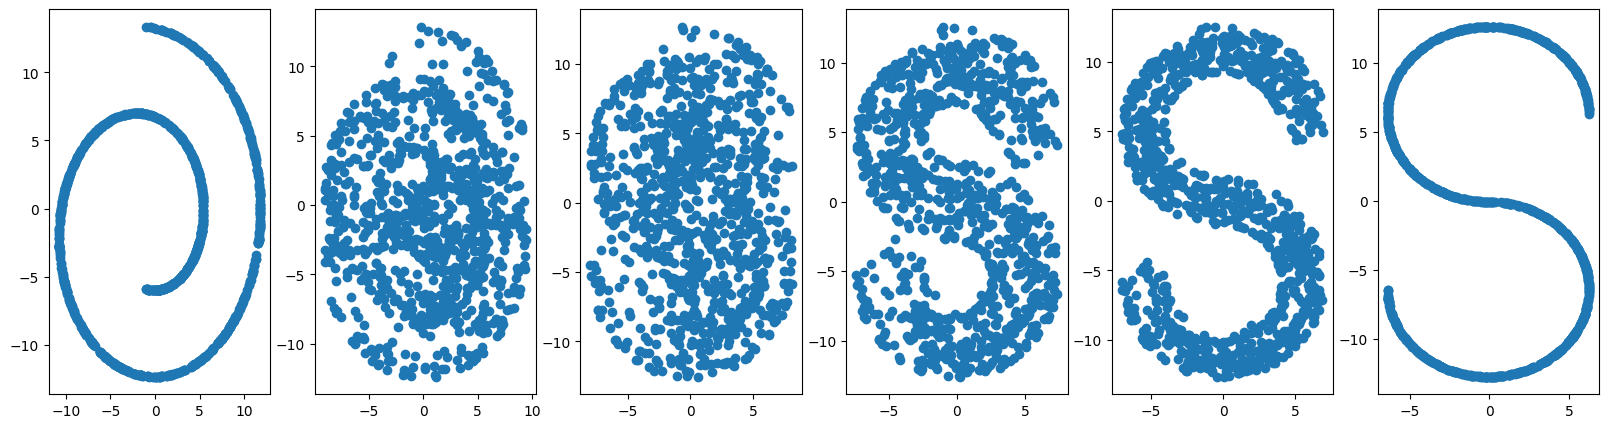

In [ ]:
device = "cuda"

diff_scheduler = Scheduler(create_symmetric_beta_schedule_1(n_timestep=5, linear_end=2e-4), device)
train_dataloader = DataLoader(train_pair_dataset, 1000, shuffle = True)
sampler = MySampler(train_dataloader)

x_0, x_1 = sampler.sample()
x_0 = x_0.to(device)
x_1 = x_1.to(device)

samples = [x_1.detach().cpu().numpy()]
x_t = x_1

for i in range(4):
    t = torch.ones(1000, dtype=torch.int64, device=device)
    tp1 = t + 1
    x_t = diff_scheduler.p_posterior(t, tp1, x_t, x_0, ot_ode=False)
    samples.append(x_t.detach().cpu().numpy())

samples.append(x_0.detach().cpu().numpy())

plt.figure(figsize=(20, 5))
for i, x_t in enumerate(samples):
    plt.subplot(1, len(samples), i + 1)
    plt.scatter(x_t[:, 0], x_t[:, 1])

plt.show()

In [ ]:
diff_scheduler.std_bwd, diff_scheduler.std_fwd, diff_scheduler.std_sb

(tensor([0.0243, 0.0221, 0.0192, 0.0149, 0.0100], device='cuda:0'),
 tensor([0.0100, 0.0149, 0.0192, 0.0221, 0.0243], device='cuda:0'),
 tensor([0.0092, 0.0124, 0.0136, 0.0124, 0.0092], device='cuda:0'))

#### Hyperparameters

Most of parameters came from the original DDGAN repository

In [ ]:
!rm -rf datasets
!mkdir -p datasets/train

In [ ]:
train_pair_dataset, dim = get_pair_dataset(10000, "scurve", "swiss", None, path_to_save="./datasets/", regime = "train")

In [ ]:
args = {
    'nz': 1,
    'num_timesteps': 4,
    'x_dim': 2,
    't_dim': 2,
    'out_dim': 2,
    'beta_min': 1e-4,
    'beta_max': 2e-4,
    'layers_G': [256, 256, 256],
    'layers_D': [256, 256, 256],
    'num_iterations': 200000,
    'batch_size': 512,
    'lr_d': 1e-4,
    'lr_g': 1e-4,
    'beta1': 0.5,
    'beta2': 0.9,
    'r1_gamma': 0.01,
    'lazy_reg': 1,
    'use_ema': True,
    'ema_decay': 0.999,
    'dataset': train_pair_dataset,
    'sampler_precalc': 1000,
    'exp_path': "./scurve2swiss/",
    'save_ckpt': True,
    'save_ckpt_every': 5000,
    'save_content':True,
    'save_content_every': 5000,
    'visualize':True,
    'visualize_every': 1001,
    'print': True,
    'print_every': 100,
    'resume': False,
}
args = dotdict(args)

In [ ]:
!rm -rf $args.exp_path
!mkdir $args.exp_path

#### Training

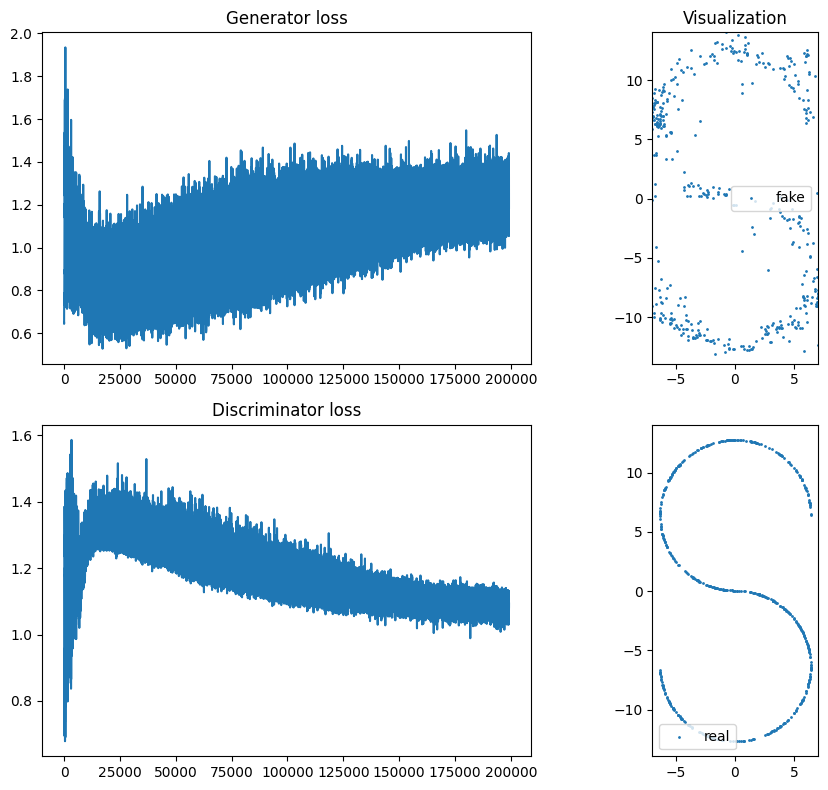

100%|█████████▉| 199214/200001 [54:05<00:39, 19.71it/s]

iteration: 199199 | G Loss: 1.2967751026153564 | D Loss: 1.1127548217773438


100%|█████████▉| 199309/200001 [54:06<00:09, 70.77it/s]

iteration: 199299 | G Loss: 1.451082468032837 | D Loss: 1.1228814125061035


100%|█████████▉| 199413/200001 [54:07<00:08, 72.31it/s]

iteration: 199399 | G Loss: 1.2382514476776123 | D Loss: 1.0940978527069092


100%|█████████▉| 199509/200001 [54:09<00:06, 72.95it/s]

iteration: 199499 | G Loss: 1.1517839431762695 | D Loss: 1.1048872470855713


100%|█████████▉| 199613/200001 [54:10<00:05, 73.32it/s]

iteration: 199599 | G Loss: 1.2909348011016846 | D Loss: 1.1268794536590576


100%|█████████▉| 199708/200001 [54:12<00:04, 72.52it/s]

iteration: 199699 | G Loss: 1.1915713548660278 | D Loss: 1.1155574321746826


100%|█████████▉| 199812/200001 [54:13<00:02, 71.91it/s]

iteration: 199799 | G Loss: 1.2467128038406372 | D Loss: 1.1103695631027222


100%|█████████▉| 199906/200001 [54:15<00:01, 64.67it/s]

iteration: 199899 | G Loss: 1.333344578742981 | D Loss: 1.080379843711853


100%|██████████| 200001/200001 [54:16<00:00, 61.41it/s]

iteration: 199999 | G Loss: 1.3365758657455444 | D Loss: 1.087386965751648
Saving content.


In [ ]:
train_model(args)

### Visualization

In [ ]:
netG = MyGenerator(
    x_dim = args.x_dim,
    t_dim = args.t_dim,
    n_t = args.num_timesteps,
    out_dim = args.out_dim,
    z_dim = args.nz,
    layers = args.layers_G
).to(device)

netD = MyDiscriminator(
    x_dim = args.x_dim,
    t_dim = args.t_dim,
    n_t = args.num_timesteps,
    layers = args.layers_D
).to(device)

checkpoint_file = os.path.join(args.exp_path, 'netG_194999.pth')
checkpoint = torch.load(checkpoint_file, map_location=device)
# init_iteration = checkpoint['iteration']
# global_iteration = init_iteration

# load G
netG.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
def gan_pred_x0_fn(x_tp1, t):
    latent_z = torch.randn((x_tp1.shape[0], args.nz), device=device)
    t = t * torch.ones((x_tp1.shape[0],), dtype=torch.int64, device=device)
    return netG(x_tp1.detach(), t, latent_z)

In [ ]:
val_pair_dataset, dim = get_pair_dataset(1000, "scurve", "swiss", None, path_to_save="./datasets/", regime = "val")

In [147]:
device = "cuda"

diff_scheduler = Scheduler(create_symmetric_beta_schedule_1(n_timestep=5, linear_end=2e-4), device)
train_dataloader = DataLoader(val_pair_dataset, 1000, shuffle = True)
sampler = MySampler(train_dataloader)

x_0, x_1 = sampler.sample()
x_0 = x_0.to(device)
x_1 = x_1.to(device)

xs, x0s = diff_scheduler.ddgan_sampling(torch.arange(0, 5), gan_pred_x0_fn, x_1, ot_ode=False)
xs.shape, x0s.shape

# samples = [x_1.detach().cpu().numpy()]
# x_t = x_1

# for i in range(4):
#     t = torch.ones(1000, dtype=torch.int64, device=device)
#     tp1 = t + 1
#     x_t = diff_scheduler.p_posterior(t, tp1, x_t, x_0, ot_ode=False)
#     samples.append(x_t.detach().cpu().numpy())

# samples.append(x_0.detach().cpu().numpy())

# plt.figure(figsize=(20, 5))
# for i, x_t in enumerate(samples):
#     plt.subplot(1, len(samples), i + 1)
#     plt.scatter(x_t[:, 0], x_t[:, 1])

# plt.show()

DDGAN sampling: 100%|██████████| 4/4 [00:00<00:00, 258.74it/s]


(torch.Size([1000, 5, 2]), torch.Size([1000, 4, 2]))

In [148]:
IMAGE_CONSTANTS = {
    "scale":1,
    "width":0.002,
    "x_range":(-15,15),
    "y_range":(-15,15),
    "figsize":(20,10)
}


def visualize2d(xs, x0, log_steps):
    fig, axs = plt.subplots(1, xs.shape[1] + 1, figsize = (20, 10))

    axs[0].scatter(x0[:, 0], x0[:, 1], c = list(range(len(x0))))
    axs[0].set_title(f"True labels")

    for ind in range(1, xs.shape[1] + 1):
        points_t = xs[:, ind - 1, :]
        axs[ind].scatter(points_t[:, 0], points_t[:, 1], c = list(range(len(points_t))))
        axs[ind].set_title(f"Points at time {log_steps[ind - 1]}")

    return fig

def save_imgs2d(log_steps, path_to_save, draw_dict):
    path_to_save = Path(path_to_save)

    for ind in range(len(log_steps)):
        plt.figure(figsize = IMAGE_CONSTANTS["figsize"])
        for name, vals in draw_dict.items():
            xs = vals["log_steps"]
            points_t = xs[:, ind, :]
            plt.scatter(points_t[:, 0], points_t[:, 1], c = vals["color"], label = name)
            plt.title(f"Points at time {log_steps[ind]}")
            if ind != 0:
                plt.quiver(points_t[:, 0], points_t[:, 1], vals["vel"][:, ind - 1, 0], vals["vel"][:, ind - 1, 1],
                        angles='xy', scale_units='xy', scale=IMAGE_CONSTANTS["scale"],
                        label = name, width =IMAGE_CONSTANTS["width"], color = vals["color"],
                        alpha = 0.3)

            plt.legend()
            plt.xlim(*IMAGE_CONSTANTS["x_range"])
            plt.ylim(*IMAGE_CONSTANTS["y_range"])
            plt.savefig(str(path_to_save / f"{log_steps[ind]}.png"))

def save_gif(path_to_imgs, path_to_save, range_list):
    import imageio

    path_to_imgs = Path(path_to_imgs)
    images = [imageio.imread(str(path_to_imgs / f"{i}.png")) for i in range_list]
    imageio.mimsave(path_to_save, images)

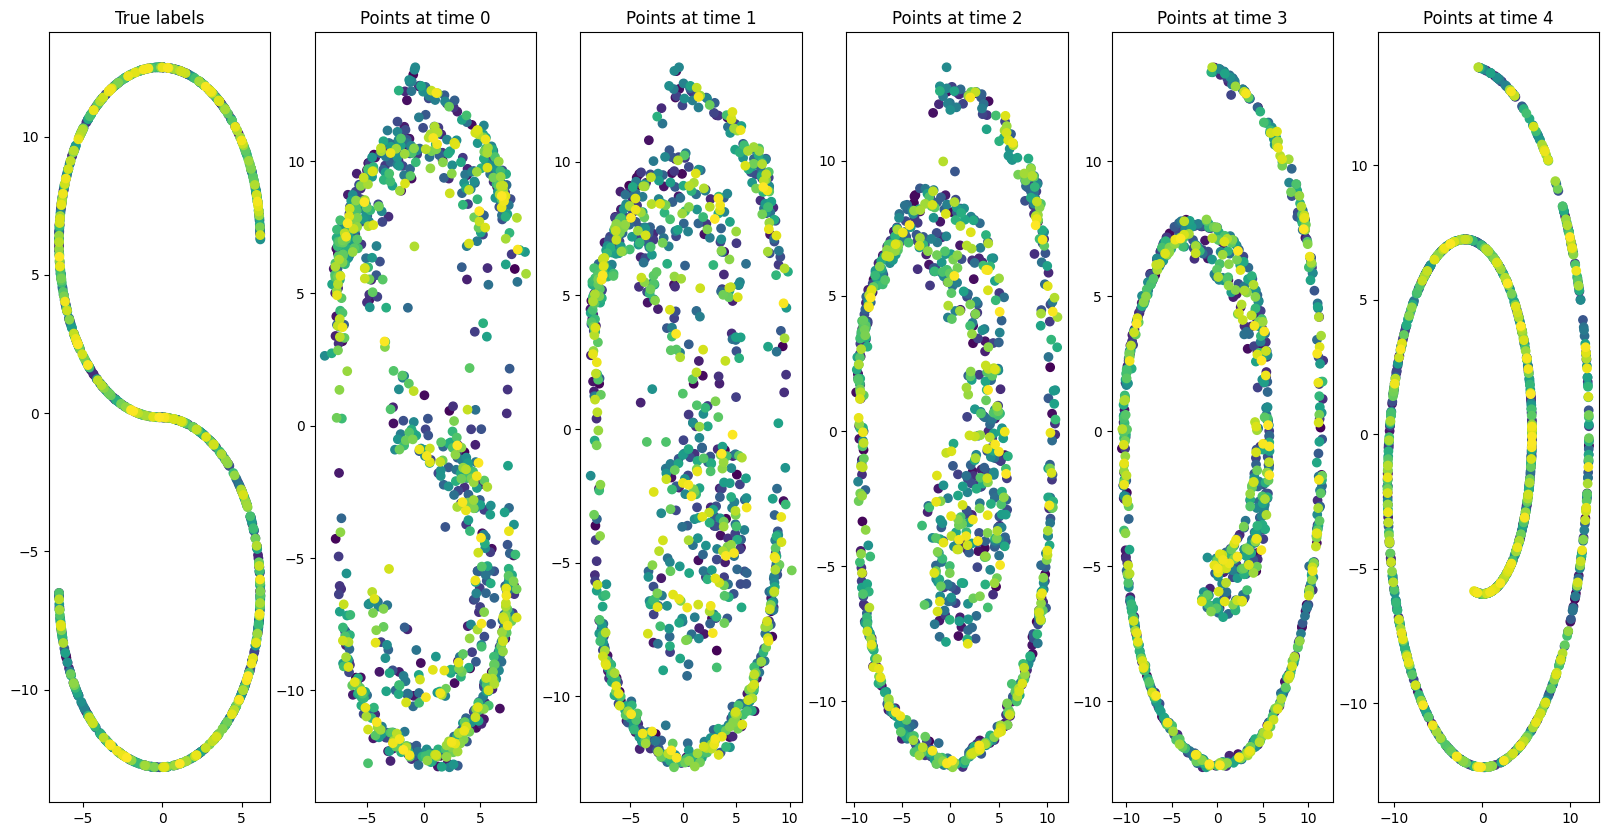

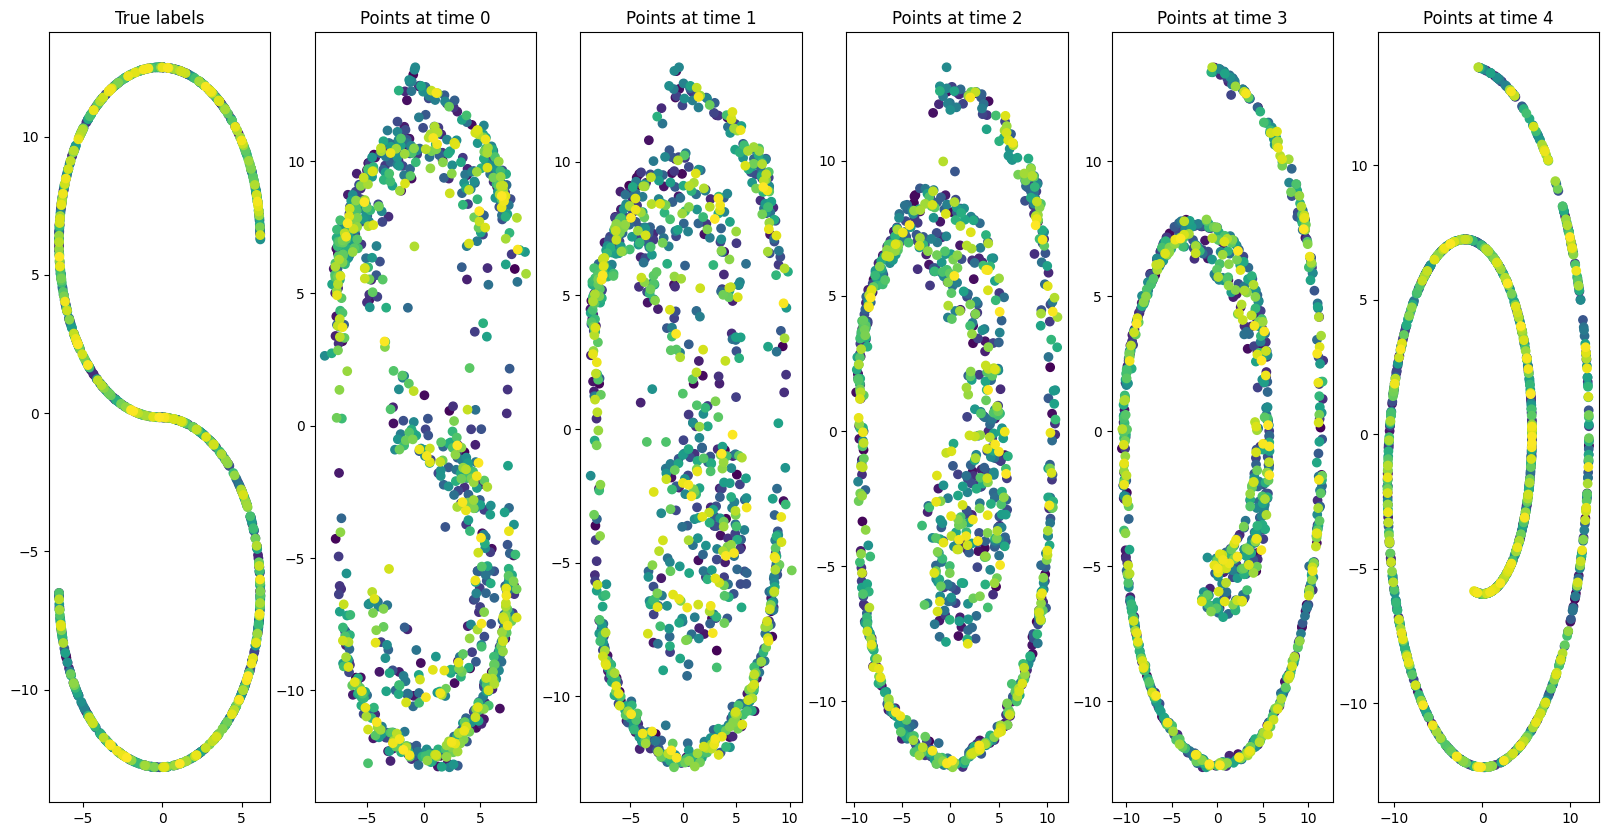

In [149]:
visualize2d(xs, x_0.detach().cpu().numpy(), np.arange(5))

In [131]:
x0s.shape

torch.Size([1000, 4, 2])

In [180]:
xss = []
for i in range(xs.shape[1] + x0s.shape[1]):
    print(i // 2)
    if i % 2 == 0:
        xss.append(xs[:, i // 2])
    else:
        xss.append(x0s[:, i // 2])

xss = torch.stack(xss[::-1], dim=1)
xss.shape

0
0
1
1
2
2
3
3
4


torch.Size([1000, 9, 2])

In [181]:
xsss = xss[:, [0, 1, 3, 5, 7]]
# xsss = xss

In [182]:
xsss.shape

torch.Size([1000, 5, 2])

In [183]:
!mkdir path_to_save_sde

mkdir: cannot create directory ‘path_to_save_sde’: File exists


In [185]:
draw_dict = {"SB GAN": {"log_steps" : xsss, "vel" : xsss[:, :-1, :] - xsss[:, 1:, :], "color" : "#1107EA" }}

save_imgs2d(np.arange(5), "./path_to_save_sde/", draw_dict)

Output hidden; open in https://colab.research.google.com to view.

In [154]:
save_gif("./path_to_save_sde_inter", "./visualization_sde_inter.gif", np.arange(8))

<ipython-input-148-187b18378b9a>:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(str(path_to_imgs / f"{i}.png")) for i in range_list]
